In [382]:
import numpy as np
import pandas as pd
import math
import scipy as sp
import netCDF4
import gsw # this will be VERY useful https://github.com/TEOS-10/GSW-Python

# 1. Download synthetic argo file (= S-file)

In [383]:
# import requests
# import urllib 
# import ftplib
import wget
import os

def download_float(dac, wmo):
    """
    dac : data center, e.g. 'coriolis'
    wmo : world id of the float (unique), e.g. 6901866
    """
    
    # check if float folder exists
    if(os.path.isdir('./floats') == False):
        print("Directory 'floats' does not exist")
        print("It's being created in your current path")
        os.mkdir(os.path.join(os.getcwd(),'floats'))
    # check if file already exists in that folder
    if(os.path.isfile(os.getcwd()+'/floats/'+str(wmo)+'_Sprof.nc') == False):
        print("File does not exist")
        print("File is being downloaded")
        print("...")
        base_url = 'ftp://ftp.ifremer.fr/ifremer/argo/dac/'
        full_url = base_url+dac+'/'+str(wmo)+'/'
        link = full_url+str(wmo)+'_Sprof.nc'
        wget.download(link, out = os.getcwd()+'/floats/')
        print("Done !")
    else:
        print("File already exists, moving on.")

In [384]:
download_float('coriolis',6900798)
#download_float('coriolis',6901866) # Black Sea, just for testing
download_float('coriolis',6900799)

File already exists, moving on.
File already exists, moving on.


# 2. Extract data from NetCDF

In [385]:
# Read data

def read_data(ncfile):
    
    # see also the doc for SYNTHETIC BGC-ARGO files: https://archimer.ifremer.fr/doc/00445/55637/75359.pdf
    nc = netCDF4.Dataset(os.getcwd()+'/floats/'+ncfile, mode='r') # add a get url download the file in a folder then read it
    # get coordinates variables
    lat = nc.variables['LATITUDE'][:].data
    lon = nc.variables['LONGITUDE'][:].data
    time = nc.variables['JULD'][:].data
    depth = nc.variables['PRES'][:].data
    depth_qc = nc.variables['PRES_QC'][:].data
    
    #other parameters
    bbp = nc.variables['BBP700'][:].data
    bbp_qc = nc.variables['BBP700_QC'][:].data
    chla = nc.variables['CHLA'][:].data
    chla_qc = nc.variables['CHLA_QC'][:].data
    temp = nc.variables['TEMP'][:].data
    temp_qc = nc.variables['TEMP_QC'][:].data
    psal = nc.variables['PSAL'][:].data
    psal_qc = nc.variables['PSAL_QC'][:].data
    
    # close netcdf
    nc.close()
    
    # put data into a Dataframe
    data = pd.DataFrame({'depth':np.concatenate(depth), 'depth_qc':np.concatenate(depth_qc), 'temp':np.concatenate(temp),
              'temp_qc':np.concatenate(temp_qc), 'psal':np.concatenate(psal), 'psal_qc':np.concatenate(psal_qc),
              'chla':np.concatenate(chla), 'chla_qc':np.concatenate(chla_qc), 'bbp':np.concatenate(bbp), 
              'bbp_qc':np.concatenate(bbp_qc)})
    
    # number of profiles in the file
    n_prof = len(time)
    
    # repeat metadata to fit data length
    points_per_profile = data.shape[0]/n_prof
    time = np.repeat(time, points_per_profile)
    lat = np.repeat(lat, points_per_profile)
    lon = np.repeat(lon, points_per_profile)
    data['time'] = time
    data['lat'] = lat
    data['lon'] = lon

    # add profile IDs in a similar way, assuming the hypothesis of constant length per profile is correct (thanks to S profiles?)
    ids = np.array(range(1,n_prof+1))
    data['id'] = np.repeat(ids, points_per_profile)
    
    # some additional cleaning
    FillValue = 99999.0
    data = data.replace(FillValue, 'NaN')
    
    return(data)

In [386]:
#data = read_data('6901866_Sprof.nc')
data = read_data('6900798_Sprof.nc') # here you choose which float you'll analyze.
#data = read_data('6900799_Sprof.nc')

In [387]:
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,time,lat,lon,id
0,4.2,b'1',8.363,b'1',35.256,b'1',NaN,b' ',NaN,b' ',22097.779155,69.088,2.434,1
1,6,b'1',8.365,b'1',35.256,b'1',3.0744,b'3',0.00310812,b'2',22097.779155,69.088,2.434,1
2,8,b'1',8.364,b'1',35.256,b'1',NaN,b' ',NaN,b' ',22097.779155,69.088,2.434,1
3,10,b'1',8.365,b'1',35.255,b'1',2.86654,b'3',0.00318367,b'2',22097.779155,69.088,2.434,1
4,12,b'1',8.363,b'1',35.254,b'1',NaN,b' ',NaN,b' ',22097.779155,69.088,2.434,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214457,1196.1,b'1',-0.446,b'1',34.908,b'1',NaN,b' ',NaN,b' ',23996.989942,77.675,-1.998,314
214458,1197.4,b'1',-0.447,b'1',34.908,b'1',NaN,b' ',NaN,b' ',23996.989942,77.675,-1.998,314
214459,NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',23996.989942,77.675,-1.998,314
214460,NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',23996.989942,77.675,-1.998,314


# 3. Some data cleaning
- convert QC bytes into integers
- remove depth where we don't have BBP data ==> this needs to be validated and check the order with the additional QCs to be applied

In [388]:
# convert QC bytes into integers
def bytes_to_int(x):
    try:
        x = int(x)
    except:
        x = 'NaN'
    return(x)

In [389]:
# apply that function where it is needed
data['temp_qc'] = data['temp_qc'].apply(bytes_to_int)
data['psal_qc'] = data['psal_qc'].apply(bytes_to_int)
data['depth_qc'] = data['depth_qc'].apply(bytes_to_int)
data['chla_qc'] = data['chla_qc'].apply(bytes_to_int)
data['bbp_qc'] = data['bbp_qc'].apply(bytes_to_int)

In [390]:
# remove negative NaN depth and negative depths
data['depth_qc'].replace(3, 'NaN', inplace=True)
data['depth_qc'].replace(4, 'NaN', inplace=True)
data = data[data.depth != 'NaN']
data = data[data.depth >= 0]

In [391]:
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,time,lat,lon,id
0,4.2,1,8.363,1,35.256,1,NaN,NaN,NaN,NaN,22097.779155,69.088,2.434,1
1,6,1,8.365,1,35.256,1,3.0744,3,0.00310812,2,22097.779155,69.088,2.434,1
2,8,1,8.364,1,35.256,1,NaN,NaN,NaN,NaN,22097.779155,69.088,2.434,1
3,10,1,8.365,1,35.255,1,2.86654,3,0.00318367,2,22097.779155,69.088,2.434,1
4,12,1,8.363,1,35.254,1,NaN,NaN,NaN,NaN,22097.779155,69.088,2.434,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214454,1190,1,-0.445,1,34.908,1,NaN,NaN,NaN,NaN,23996.989942,77.675,-1.998,314
214455,1192,1,-0.446,1,34.908,1,NaN,NaN,NaN,NaN,23996.989942,77.675,-1.998,314
214456,1194,1,-0.446,1,34.908,1,NaN,NaN,NaN,NaN,23996.989942,77.675,-1.998,314
214457,1196.1,1,-0.446,1,34.908,1,NaN,NaN,NaN,NaN,23996.989942,77.675,-1.998,314


# 4. Quality controls (to be done) => couldn't find any tests in Dall'Olmo 2012

In [392]:
# to be done : apply some additionnal QC on BBP data
# QUESTION: before of after removing the NaN (if needed) => see below

# QC from https://archimer.ifremer.fr/doc/00491/60262/63668.pdf

# let's apply those from ARGO
# replace QC 3 & 4 with NaN
data['temp_qc'].replace(3, 'NaN', inplace=True)
data['temp_qc'].replace(4, 'NaN', inplace=True)
data['psal_qc'].replace(3, 'NaN', inplace=True)
data['psal_qc'].replace(4, 'NaN', inplace=True)
data['bbp_qc'].replace(3, 'NaN', inplace=True)
data['bbp_qc'].replace(4, 'NaN', inplace=True)
data['chla_qc'].replace(3, 'NaN', inplace=True)
data['chla_qc'].replace(4, 'NaN', inplace=True)

In [393]:
data = data[data.temp_qc != 'NaN']
data = data[data.psal_qc != 'NaN']
#data = data[data.bbp_qc != 'NaN'] # will be applied AFTER the computation of the MLD
# I am not applying the QC on chla on purpose because I know that Chla QC is very tricky .. we could lose entire profiles
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,time,lat,lon,id
0,4.2,1,8.363,1,35.256,1,NaN,NaN,NaN,NaN,22097.779155,69.088,2.434,1
1,6,1,8.365,1,35.256,1,3.0744,NaN,0.00310812,2,22097.779155,69.088,2.434,1
2,8,1,8.364,1,35.256,1,NaN,NaN,NaN,NaN,22097.779155,69.088,2.434,1
3,10,1,8.365,1,35.255,1,2.86654,NaN,0.00318367,2,22097.779155,69.088,2.434,1
4,12,1,8.363,1,35.254,1,NaN,NaN,NaN,NaN,22097.779155,69.088,2.434,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214454,1190,1,-0.445,1,34.908,1,NaN,NaN,NaN,NaN,23996.989942,77.675,-1.998,314
214455,1192,1,-0.446,1,34.908,1,NaN,NaN,NaN,NaN,23996.989942,77.675,-1.998,314
214456,1194,1,-0.446,1,34.908,1,NaN,NaN,NaN,NaN,23996.989942,77.675,-1.998,314
214457,1196.1,1,-0.446,1,34.908,1,NaN,NaN,NaN,NaN,23996.989942,77.675,-1.998,314


# 5. Compute density

In [394]:
# compute density
# see https://teos-10.github.io/GSW-Python/
psal = gsw.SA_from_SP(np.array(data['psal']), np.array(data['depth']), np.array(data['lon']), np.array(data['lat']))
temp = gsw.CT_from_t(psal, np.array(data['temp']), np.array(data['depth']))
sigma = gsw.sigma0(psal, temp)
data['sigma'] = sigma

# 6. Computation of the Mixed Layer Depth (MLD)
- sigma criteria : 0.03 kg/m³ instead of 0.1
- depth ref = 10 m
- See Kara et al., 2003:  https://doi.org/10.1029/2000JC000736)


- /!\ some issues are still present with MLD computation .. check ID = 20 for e.g. => better check for a diff of 0.03 in both directions .. looks like they are density inversions at some point.. => well maybe not actually: see http://bora.uib.no/bitstream/handle/1956/1722/paper_mld_BORA.pdf?sequence=1&isAllowed=y and https://www.researchgate.net/figure/Month-of-maximum-MLD-reached-in-the-North-Atlantic-for-a-the-DT-02C-climatology_fig3_229010378

In [395]:
# mmmh need to adress two issues, the presence of NaN and when we don't have enough data before 10?

sigma_criteria = 0.03
depth_ref = 10 # need to be adapted ?? otherwise there could be issues with bad PSAL and TEMP data
from scipy.interpolate import interp1d

def compute_MLD(group): # this will probably need to be adapted after QC application (for NaN for instance, or if sigma data between the surface and 10m are bad)
    
    # subset group to avoid NaN issue (i.e. TypeError: '<' not supported between instances of 'str' and 'float')
    tmp = group[['depth', 'sigma']]
    tmp = tmp[tmp.sigma != 'NaN']
    #tmp = tmp[tmp.depth != 'NaN']
    
    # check if first depth is below depth_ref
    if(np.min(tmp['depth'] >= depth_ref)):
        group['MLD'] = np.repeat('NaN', group.shape[0])
    else:
        # approx sigma et 10m
        f = interp1d(tmp['depth'], tmp['sigma']) # linear interp
        # we define sigma_surface as sigma at 10m
        sigma_surface = float(f(depth_ref))
        MLD = np.min(tmp[tmp['sigma'] >= sigma_surface + sigma_criteria]['depth'])
        group['MLD'] = np.repeat(MLD, group.shape[0])
    return(group)

data = data.groupby('id').apply(compute_MLD)

# only keep data for which we have a MLD
data = data[data.MLD != 'NaN']

/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packa

/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packa

/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packa

/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packa

/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packa

/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packa

/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packa

In [396]:
np.unique(data['MLD'])

array([10.420000076293945, 10.680000305175781, 10.770000457763672, 12.0,
       14.0, 15.050000190734863, 15.130000114440918, 15.1899995803833,
       15.369999885559082, 15.4399995803833, 15.449999809265137,
       15.529999732971191, 15.539999961853027, 15.8100004196167, 16.0,
       17.899999618530273, 18.0, 19.940000534057617, 20.0, 22.0, 24.0,
       25.06999969482422, 25.290000915527344, 25.3700008392334,
       25.520000457763672, 25.530000686645508, 25.549999237060547,
       25.6200008392334, 25.649999618530273, 26.0, 28.0, 30.0,
       30.43000030517578, 31.899999618530273, 32.0, 34.0,
       34.91999816894531, 35.369998931884766, 35.75, 36.0, 38.0, 40.0,
       40.470001220703125, 40.68000030517578, 42.0, 42.099998474121094,
       44.0, 44.79999923706055, 44.9900016784668, 45.2400016784668,
       45.31999969482422, 45.380001068115234, 45.38999938964844, 46.0,
       48.0, 51.900001525878906, 52.0, 54.880001068115234,
       54.939998626708984, 55.2400016784668, 56.0, 58.0,

In [397]:
# check MLD range
print(np.min(np.unique(data['MLD'])))
print(np.max(np.unique(data['MLD'])))

10.420000076293945
560.0


# Now that the MLD has been computed, we can remove data where bbp is NaN (core-argo vs b-argo)

In [398]:
# remove depth where we don't have BBP data
# NOTE : is that correct? If not, we may have troubles with the median filter. OR we can let NaN be present in
# BBP data but then write a median filter that does not take them into account? Which is probably the case? 
# To check with Giorgio
data = data[data.bbp != 'NaN']
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,time,lat,lon,id,sigma,MLD
1,6,1,8.365,1,35.256,1,3.0744,NaN,0.00310812,2,22097.779155,69.088,2.434,1,27.421695,18
3,10,1,8.365,1,35.255,1,2.86654,NaN,0.00318367,2,22097.779155,69.088,2.434,1,27.420981,18
6,16,1,8.176,1,35.249,1,4.23725,NaN,0.00368133,2,22097.779155,69.088,2.434,1,27.445372,18
8,20,1,7.59,1,35.237,1,5.99444,NaN,0.00288482,2,22097.779155,69.088,2.434,1,27.523479,18
11,26,1,7.514,1,35.238,1,3.63502,NaN,0.00203976,2,22097.779155,69.088,2.434,1,27.535553,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214342,974.86,1,-0.22686,8,34.915,8,0.0072,NaN,0.000278045,2,23996.989942,77.675,-1.998,314,28.054931,12
214356,1000.09,1,-0.27136,8,34.913,8,0.0072,NaN,0.000266734,2,23996.989942,77.675,-1.998,314,28.055628,12
214382,1050.12,1,-0.321021,8,34.912,8,0.0072,NaN,0.000266619,2,23996.989942,77.675,-1.998,314,28.057432,12
214408,1100.52,1,-0.36778,8,34.91,8,0.0144,NaN,0.000266513,2,23996.989942,77.675,-1.998,314,28.058249,12


# 6. Some plots

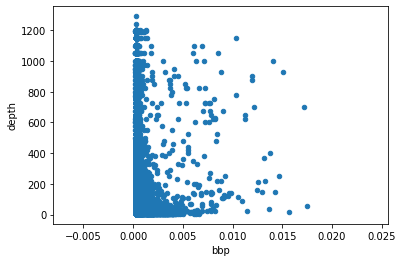

In [399]:
data.plot.scatter(x = 'bbp', y = 'depth')

In [400]:
# # plot some data
# from plotnine import ggplot, aes, geom_point, geom_line
# tmp = data[data.id == 1][:10]
# tmp.reset_index(inplace=True)#, drop=True)
# (ggplot(data = tmp) + aes(x = 'temp', y = 'depth') + geom_point()) #+ scale_y_reverse()

# ==> for an unknown reason, plotnine does not behave like it used to..

# 7. Remove dark offset  ==> remark maybe it's just ONE value per float and not per profile

In [401]:
def remove_dark_offset(group):
    min_bbp = np.nanmin(group['bbp'])
    group['bbp'] = group['bbp'] - min_bbp
    return(group)

In [402]:
data = data.groupby('id').apply(remove_dark_offset)

# 8. Apply median filter on BBP data

In [403]:
# median filter on BBP data ==> this needs to be done for EACH profile individually
from scipy import signal

# def medfilt (x, k):
#     """Apply a length-k median filter to a 1D array x.
#     Boundaries are extended by repeating endpoints.
#     """
#     assert k % 2 == 1, "Median filter length must be odd."
#     assert x.ndim == 1, "Input must be one-dimensional."
#     k2 = (k - 1) // 2
#     y = np.zeros ((len (x), k), dtype=x.dtype)
#     y[:,k2] = x
#     for i in range (k2):
#         j = k2 - i
#         y[j:,i] = x[:-j]
#         y[:j,i] = x[0]
#         y[:-j,-(i+1)] = x[j:]
#         y[-j:,-(i+1)] = x[-1]
#     return np.median (y, axis=1)

# def medianfilter(group):
#     smoothed = signal.medfilt(group['bbp'],5) # kernel size = 5
#     return(pd.Series(smoothed)) # apply on dataframe MUST return a dataframe, a series or a scaler, not a numpy array

# # not a pretty code but it works ..
# # grouped['bbp'].apply(lambda x: signal.medfilt(x, kernel_size = 5))
# tmp = data.groupby('id').apply(medianfilter)
# tmp = tmp.reset_index()
# data['bbp'] = np.array(tmp[0])

def medianfilter(group):
    smoothed = signal.medfilt(group['bbp'],5) # kernel size = 5
    group['bbp'] = smoothed
    return(group)

tmp = data.groupby('id').apply(medianfilter)

# 9. Convert BBP to POC

In [404]:
# some criteria (NB: empirical factors)
withinMLD = 37.530
belowMLD = 31.620

def BBP_to_POC(group):
    MLD = np.max(group['MLD'])
    # POC from BBP
    # within MLD
    tmp1 = group[group.depth <= MLD]['bbp']*withinMLD
    # below MLD
    tmp2 = group[group.depth > MLD]['bbp']*belowMLD
    # concat data
    group['poc'] = pd.concat([tmp1, tmp2])
    return(group)

In [405]:
data = data.groupby('id').apply(BBP_to_POC)

In [406]:
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,time,lat,lon,id,sigma,MLD,poc
1,6,1,8.365,1,35.256,1,3.0744,NaN,0.00286396,2,22097.779155,69.088,2.434,1,27.421695,18,0.107484
3,10,1,8.365,1,35.255,1,2.86654,NaN,0.0029395,2,22097.779155,69.088,2.434,1,27.420981,18,0.110319
6,16,1,8.176,1,35.249,1,4.23725,NaN,0.00343716,2,22097.779155,69.088,2.434,1,27.445372,18,0.128997
8,20,1,7.59,1,35.237,1,5.99444,NaN,0.00264065,2,22097.779155,69.088,2.434,1,27.523479,18,0.0834974
11,26,1,7.514,1,35.238,1,3.63502,NaN,0.0017956,2,22097.779155,69.088,2.434,1,27.535553,18,0.0567768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214342,974.86,1,-0.22686,8,34.915,8,0.0072,NaN,8.91325e-05,2,23996.989942,77.675,-1.998,314,28.054931,12,0.00281837
214356,1000.09,1,-0.27136,8,34.913,8,0.0072,NaN,7.78218e-05,2,23996.989942,77.675,-1.998,314,28.055628,12,0.00246073
214382,1050.12,1,-0.321021,8,34.912,8,0.0072,NaN,7.77072e-05,2,23996.989942,77.675,-1.998,314,28.057432,12,0.0024571
214408,1100.52,1,-0.36778,8,34.91,8,0.0144,NaN,7.76007e-05,2,23996.989942,77.675,-1.998,314,28.058249,12,0.00245373


# 10. Convert julian time to human time

In [407]:
import datetime
def julian_to_human(group):
    gregorian_time = datetime.date(1950, 1, 1) + datetime.timedelta(days=np.min(group['time']))
    #group['human_time'] = np.repeat(gregorian_time.strftime('%d-%m-%Y'), group.shape[0])
    group['human_time'] = np.repeat(gregorian_time, group.shape[0])
    return(group)

data = data.groupby('id').apply(julian_to_human)

# 11. Bottom of the euphotic zone
3 (4) methods:
- With PAR data but let's forget that, it's not on all BGC float
- Chla empirical (I like this one, it's so easy to use)
- Based on Chla relative values (shape of the profile and not absolute values)
- script from Lionel about a paper from Morel 2001

### A) Based on Chla relative values

In [408]:
# then in that case, we must also apply a median filter on chla data
def medianfilter_chla(group):
    smoothed = signal.medfilt(group['chla'],5) # kernel size = 5
    group['chla'] = smoothed
    return(group)

data = data.groupby('id').apply(medianfilter_chla)

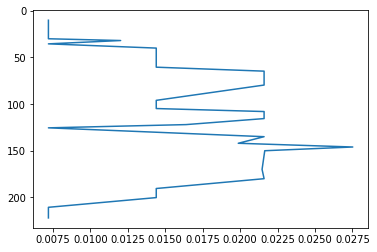

In [409]:
# Let's start with the shape of the Chla profile
# plot some data
tmp = data[data.id == 20] # choose a profil ID here 
tmp = tmp[tmp.depth < 250]

#tmp.plot.scatter(x = 'chla', y = 'depth')
from matplotlib import pyplot as plt
plt.gca().invert_yaxis()
plt.plot(tmp['chla'], tmp['depth'])

In [410]:
# based on some profiles, I decided to put the threshold of Chla at 0.1 mg/m³ (pay attention to the units in Morel et al., 2001)
# compare the value of the depth found here with the one of Morel, should be close. Let's also compute the empirical equation to see.
chla_threshold = 0.1

## NOTE : not sure it's the good way to go

In [411]:
z_eu_chla_threshold = min(tmp[tmp.chla < chla_threshold].depth)
z_eu_chla_threshold

10.15999984741211

### B) Based on empirical relationship

In [412]:
chla_10m = float(tmp.iloc[(tmp['depth']-10).abs().argsort()[:1]]['chla']) # chla at ~ 10 m (or the closest)
z_eu_empir = 1/(0.012939+(0.018151*chla_10m))
z_eu_empir

76.51292528039725

### C) Morel's method (to be done)

# Which method is the best to compute a z_eu ? Needs to be discussed

In [413]:
# compute the z_eu for each profile, I'm choosing the satellite method (empirical)
def compute_z_eu(group):
    chla_10m = float(group.iloc[(group['depth']-10).abs().argsort()[:1]]['chla']) # chla at ~ 10 m (or the closest)
    z_eu_empir = 1/(0.012939+(0.018151*chla_10m))
    group['z_eu'] = z_eu_empir
    return(group)

In [414]:
data = data.groupby('id').apply(compute_z_eu)

In [415]:
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,time,lat,lon,id,sigma,MLD,poc,human_time,z_eu
1,6,1,8.365,1,35.256,1,4.23725,NaN,0.00286396,2,22097.779155,69.088,2.434,1,27.421695,18,0.107484,2010-07-02,11.129746
3,10,1,8.365,1,35.255,1,4.23725,NaN,0.0029395,2,22097.779155,69.088,2.434,1,27.420981,18,0.110319,2010-07-02,11.129746
6,16,1,8.176,1,35.249,1,4.23725,NaN,0.00343716,2,22097.779155,69.088,2.434,1,27.445372,18,0.128997,2010-07-02,11.129746
8,20,1,7.59,1,35.237,1,5.99444,NaN,0.00264065,2,22097.779155,69.088,2.434,1,27.523479,18,0.0834974,2010-07-02,11.129746
11,26,1,7.514,1,35.238,1,3.63502,NaN,0.0017956,2,22097.779155,69.088,2.434,1,27.535553,18,0.0567768,2010-07-02,11.129746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214342,974.86,1,-0.22686,8,34.915,8,0.0072,NaN,8.91325e-05,2,23996.989942,77.675,-1.998,314,28.054931,12,0.00281837,2015-09-13,63.761558
214356,1000.09,1,-0.27136,8,34.913,8,0.0072,NaN,7.78218e-05,2,23996.989942,77.675,-1.998,314,28.055628,12,0.00246073,2015-09-13,63.761558
214382,1050.12,1,-0.321021,8,34.912,8,0.0072,NaN,7.77072e-05,2,23996.989942,77.675,-1.998,314,28.057432,12,0.0024571,2015-09-13,63.761558
214408,1100.52,1,-0.36778,8,34.91,8,0.0144,NaN,7.76007e-05,2,23996.989942,77.675,-1.998,314,28.058249,12,0.00245373,2015-09-13,63.761558


## Thickness of the layer where particles can potentially be produced by photosynthesis

In [416]:
# I am gonna keep the empirical z_eu
def compute_zp(group):
    z_p = max(min(group['MLD']), min(group['z_eu']))
    group['z_p'] = z_p
    return(group)

In [417]:
data = data.groupby('id').apply(compute_zp)

In [418]:
# np.unique(data[data.MLD > 200]['human_time'])
# np.unique(data[data.MLD > 200]['MLD'])

# Check that flux is ~ 0 at 1000m (see hypotheses)
- For those two floats, it is the case but this step needs to be reminded when going global

# Integration of POC in different layers

In [419]:
tmp = data[data.id == 20]
tmp

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,time,lat,lon,id,sigma,MLD,poc,human_time,z_eu,z_p
12983,10.16,1,5.38308,8,35.2191,8,0.0072,NaN,7.42273e-05,2,22295.826597,70.91,0.815,20,27.804943,504,0.00278575,2011-01-16,76.512925,504.0
12986,15.29,1,5.384,8,35.2103,8,0.0072,NaN,0.000130347,2,22295.826597,70.91,0.815,20,27.797886,504,0.00489191,2011-01-16,76.512925,504.0
12990,20.42,1,5.384,8,35.2112,8,0.0072,NaN,7.42821e-05,2,22295.826597,70.91,0.815,20,27.798622,504,0.00278781,2011-01-16,76.512925,504.0
12993,24.6,1,5.3837,8,35.2176,8,0.0072,NaN,5.18253e-05,2,22295.826597,70.91,0.815,20,27.803863,504,0.001945,2011-01-16,76.512925,504.0
12996,30,1,5.384,1,35.229,1,0.0072,NaN,6.27293e-05,2,22295.826597,70.91,0.815,20,27.812984,504,0.00235423,2011-01-16,76.512925,504.0
12997,31.9,1,5.384,1,35.227,1,0.0120225,NaN,5.93162e-05,8,22295.826597,70.91,0.815,20,27.811431,504,0.00222614,2011-01-16,76.512925,504.0
12999,35.47,1,5.38574,8,35.2275,8,0.0072,NaN,5.18197e-05,2,22295.826597,70.91,0.815,20,27.811646,504,0.00194479,2011-01-16,76.512925,504.0
13002,40,1,5.386,1,35.224,1,0.0144,NaN,6.30206e-05,2,22295.826597,70.91,0.815,20,27.808934,504,0.00236516,2011-01-16,76.512925,504.0
13005,45.43,1,5.385,8,35.2237,8,0.0144,NaN,8.54714e-05,2,22295.826597,70.91,0.815,20,27.808911,504,0.00320774,2011-01-16,76.512925,504.0
13009,50.65,1,5.38567,8,35.2263,8,0.0144,NaN,5.18129e-05,2,22295.826597,70.91,0.815,20,27.810976,504,0.00194454,2011-01-16,76.512925,504.0


In [420]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.simps.html
# https://en.wikipedia.org/wiki/Simpson%27s_rule

# integration over the whole profile (just a check)
x = np.array(tmp['depth'])
y = np.array(tmp['poc'])
from scipy import integrate
integrate.simps(y,x)

2.076093710849265

In [421]:
def integrate_poc(depth_min, depth_max, data):
    data = data[(data.depth > depth_min) & (data.depth < depth_max)]
    x = np.array(data.depth)
    y = np.array(data.poc)
    return(integrate.simps(y,x))

In [422]:
def compute_carbon_stocks(group):
    
    # 0-1000m => check in the paper iPOC_0_1000 
    iPOC_0_1000 = integrate_poc(0, 1000, group)
    group['iPOC_0_1000'] = iPOC_0_1000
    
    # 0 -> zp : 'productive layer' or iPOC_0_zp
    zp = min(group['z_p'])
    iPOC_0_zp = integrate_poc(0, zp, group)
    group['iPOC_0_zp'] = iPOC_0_zp
    
    # zp -> 1000m : 'mesopelagic layer' or iPOC_zp_1000
    iPOC_zp_1000 = integrate_poc(zp, 1000, group)
    group['iPOC_zp_1000'] = iPOC_zp_1000
    
    # other stocks in the meso layer such as iPOC_zp+zi_1000
    # zi = 50, 100, 200, 300, 400
    
    zi = 50 
    try: # needed to be added when MLD is so deep that we are close to z_max (i.e. 1000m) hence flux integration can be buggy
        iPOC_zpzi50_1000 = integrate_poc(zp+zi, 1000, group)
        group['iPOC_zp+zi50_1000'] = iPOC_zpzi50_1000
    except:
        group['iPOC_zp+zi50_1000'] = 'NaN'
    
    zi = 100
    try:
        iPOC_zpzi100_1000 = integrate_poc(zp+zi, 1000, group)
        group['iPOC_zp+zi100_1000'] = iPOC_zpzi100_1000
    except:
        group['iPOC_zp+zi100_1000'] = 'NaN'
    
    zi = 200
    try:
        iPOC_zpzi200_1000 = integrate_poc(zp+zi, 1000, group)
        group['iPOC_zp+zi200_1000'] = iPOC_zpzi200_1000
    except:
        group['iPOC_zp+zi200_1000'] = 'NaN'
    
    zi = 300
    try: 
        iPOC_zpzi300_1000 = integrate_poc(zp+zi, 1000, group)
        group['iPOC_zp+zi300_1000'] = iPOC_zpzi300_1000
    except:
        group['iPOC_zp+zi300_1000'] = 'NaN'
    
    zi = 400
    try:
        iPOC_zpzi400_1000 = integrate_poc(zp+zi, 1000, group)
        group['iPOC_zp+zi400_1000'] = iPOC_zpzi400_1000
    except:
        group['iPOC_zp+zi400_1000'] = 'NaN'
    
    return(group)

In [423]:
#import ipdb; ipdb.set_trace() # debugging starts here

In [424]:
data = data.groupby('id').apply(compute_carbon_stocks)
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,...,z_eu,z_p,iPOC_0_1000,iPOC_0_zp,iPOC_zp_1000,iPOC_zp+zi50_1000,iPOC_zp+zi100_1000,iPOC_zp+zi200_1000,iPOC_zp+zi300_1000,iPOC_zp+zi400_1000
1,6,1,8.365,1,35.256,1,4.23725,NaN,0.00286396,2,...,11.129746,18.000000,10.243946,1.142337,8.458028,5.843988,4.967885,3.883744,3.126939,2.289509
3,10,1,8.365,1,35.255,1,4.23725,NaN,0.0029395,2,...,11.129746,18.000000,10.243946,1.142337,8.458028,5.843988,4.967885,3.883744,3.126939,2.289509
6,16,1,8.176,1,35.249,1,4.23725,NaN,0.00343716,2,...,11.129746,18.000000,10.243946,1.142337,8.458028,5.843988,4.967885,3.883744,3.126939,2.289509
8,20,1,7.59,1,35.237,1,5.99444,NaN,0.00264065,2,...,11.129746,18.000000,10.243946,1.142337,8.458028,5.843988,4.967885,3.883744,3.126939,2.289509
11,26,1,7.514,1,35.238,1,3.63502,NaN,0.0017956,2,...,11.129746,18.000000,10.243946,1.142337,8.458028,5.843988,4.967885,3.883744,3.126939,2.289509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214342,974.86,1,-0.22686,8,34.915,8,0.0072,NaN,8.91325e-05,2,...,63.761558,63.761558,4.654599,0.731317,3.865541,3.442025,3.033585,2.304447,1.681910,1.333729
214356,1000.09,1,-0.27136,8,34.913,8,0.0072,NaN,7.78218e-05,2,...,63.761558,63.761558,4.654599,0.731317,3.865541,3.442025,3.033585,2.304447,1.681910,1.333729
214382,1050.12,1,-0.321021,8,34.912,8,0.0072,NaN,7.77072e-05,2,...,63.761558,63.761558,4.654599,0.731317,3.865541,3.442025,3.033585,2.304447,1.681910,1.333729
214408,1100.52,1,-0.36778,8,34.91,8,0.0144,NaN,7.76007e-05,2,...,63.761558,63.761558,4.654599,0.731317,3.865541,3.442025,3.033585,2.304447,1.681910,1.333729


In [425]:
# check stock max 
max(data['iPOC_0_1000'])

22.613322574342757

In [426]:
# let's just plot full stock (0-1000) over time to see if the trends are consistent with the paper
test = data[['human_time', 'iPOC_0_1000']].drop_duplicates()
test

,human_time,iPOC_0_1000
1,2010-07-02,10.243946
684,2010-07-12,9.228206
1367,2010-07-22,8.097219
2051,2010-08-01,9.924965
2735,2010-08-11,8.199228
...,...,...
211049,2015-08-24,5.467063
211731,2015-08-29,7.978123
212415,2015-09-03,5.791464
213098,2015-09-08,9.731160


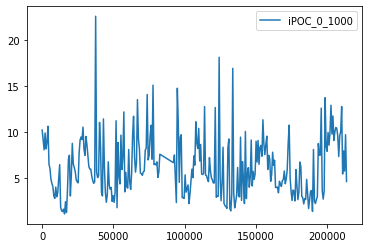

In [427]:
# attention, total stock has been SMOOTHED so the pic was surely erased in Fig. 3
test.plot()

# Let's (try to) replicate Fig. 2

In [428]:
from pylab import *
from matplotlib import pyplot as plt
from matplotlib import dates

from datetime import datetime, timedelta
from datetime import date

import cmocean
import matplotlib.dates as mdates

In [429]:
# data to plot
x = np.array(data['human_time'])
y = np.array(data['depth'])
z = np.array(data['bbp'])

# compute log10 BBP
# import math
# z = math.log10(z)
# see https://stackoverflow.com/questions/47208473/attributeerror-numpy-float64-object-has-no-attribute-log10/47208873#47208873
z = np.log10(z.astype(np.float64))
# np.log10(list(z)) # also work but np.log10(z) does NOT work


/home/flo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


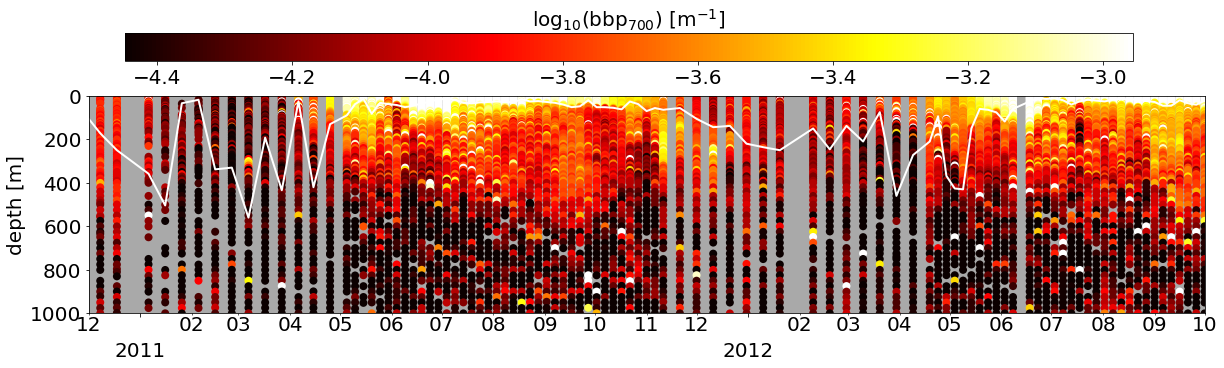

In [430]:
# cmap = cmocean.cm.tempo_r
# cmap = mpl.cm.RdYlBu
# cmap = mpl.cm.RdYlBu_r
# cmap = mpl.cm.jet
# cmap = mpl.cm.magma
cmap = mpl.cm.hot


vmin = np.percentile(z, 15) # "min color range"
vmax = np.percentile(z, 95) 
ymax = 1000 # depth max to plot
title = '$\log_{10}$(bbp$_{700}$) [m$^{-1}$]'

# see matplotlib tuto at https://matplotlib.org/3.3.2/tutorials/introductory/usage.html

fig, ax = plt.subplots(figsize=(20, 4)) # Create a figure containing a single axes.
ax.set_facecolor('darkgrey')
# fig = plt.figure(1, figsize=(20, 6))
# ax = fig.add_subplot(111, axisbg='#E6E6E6')
ax.scatter(x, y, s=64, c=z, marker='o', edgecolors='none', vmin=vmin, vmax=vmax, cmap=cmap) # Plot data on the axes.
ax.set_ylabel('depth [m]', fontsize = 20)
#ax.set_title(title, fontsize = 20)
ylim([0, ymax])
plt.gca().invert_yaxis()

#####   set ticks and  labels
months = mdates.MonthLocator(interval=1)
years = mdates.YearLocator() 

datemin = datetime.strptime('2010-12-01', '%Y-%m-%d').date()
datemin = datemin.toordinal()
datemax = datetime.strptime('2012-10-01', '%Y-%m-%d').date()
datemax = datemax.toordinal()

ax.set_xlim(datemin, datemax)

ax.xaxis.set_minor_locator(months)
ax.xaxis.set_major_locator(years)
fmt = mdates.DateFormatter('%m')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(fmt)

ax.tick_params(axis='x', which='major', direction='out', pad=25, labelsize=20)
ax.tick_params(axis='x', which='minor', direction='out', pad=0.5, labelsize=20)
ax.tick_params(axis='both', which='both', labelsize=20)

# add mld data
mld = np.array(data[['MLD', 'human_time']].drop_duplicates().MLD)
time_mld = np.array(data[['MLD', 'human_time']].drop_duplicates().human_time)
ax.plot(time_mld, mld, 'w-', lw = 2)

# add colorbar
ax1 = fig.add_axes([0.15, 1, .7, .1]) # left (+ for left), up (+ for up), length, thickness

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                       norm=norm,
                       orientation='horizontal')

cb1.ax.set_title(title, fontsize = 20)
cb1.ax.tick_params(labelsize=20) 

imaxes = gca()
axes(cb1.ax)
axes(imaxes)

# What about Fig. 3?

In [431]:
data.columns

Index(['depth', 'depth_qc', 'temp', 'temp_qc', 'psal', 'psal_qc', 'chla',
       'chla_qc', 'bbp', 'bbp_qc', 'time', 'lat', 'lon', 'id', 'sigma', 'MLD',
       'poc', 'human_time', 'z_eu', 'z_p', 'iPOC_0_1000', 'iPOC_0_zp',
       'iPOC_zp_1000', 'iPOC_zp+zi50_1000', 'iPOC_zp+zi100_1000',
       'iPOC_zp+zi200_1000', 'iPOC_zp+zi300_1000', 'iPOC_zp+zi400_1000'],
      dtype='object')

In [432]:
data2 = data[['human_time', 'iPOC_0_1000', 'iPOC_0_zp','iPOC_zp_1000','iPOC_zp+zi50_1000',
             'iPOC_zp+zi100_1000', 'iPOC_zp+zi200_1000', 'iPOC_zp+zi300_1000', 'iPOC_zp+zi400_1000',
             'MLD']].drop_duplicates()
data2

,human_time,iPOC_0_1000,iPOC_0_zp,iPOC_zp_1000,iPOC_zp+zi50_1000,iPOC_zp+zi100_1000,iPOC_zp+zi200_1000,iPOC_zp+zi300_1000,iPOC_zp+zi400_1000,MLD
1,2010-07-02,10.243946,1.142337,8.458028,5.843988,4.967885,3.883744,3.126939,2.289509,18
684,2010-07-12,9.228206,2.962005,6.019133,4.314104,3.409405,2.407798,1.734423,1.231578,22
1367,2010-07-22,8.097219,2.389940,5.491047,4.661706,3.825140,2.264262,1.290348,0.884374,18
2051,2010-08-01,9.924965,1.122550,8.587824,6.822852,5.895650,4.112504,3.129485,2.278178,12
2735,2010-08-11,8.199228,1.827724,6.225577,4.918171,4.190889,2.817494,2.217046,1.184999,15.81
...,...,...,...,...,...,...,...,...,...,...
211049,2015-08-24,5.467063,1.242543,4.039606,3.021540,2.329963,1.509403,0.927099,0.528631,28
211731,2015-08-29,7.978123,1.921222,5.885490,4.529199,3.455296,2.426091,1.873503,1.456855,42
212415,2015-09-03,5.791464,1.201869,4.288735,3.493615,3.084294,2.249433,1.846791,1.020535,40
213098,2015-09-08,9.731160,0.827496,8.765546,8.123068,7.644479,3.355063,2.051544,1.612504,10.77


In [433]:
# remove NaN otherwise matplotlib will not work. It should only concerns stocks that are NaN which is the same as 0
data2 = data2.replace('NaN', 0)

# data to plot
x = np.array(data2['human_time'])
iPOC_0_1000 = np.array(data2['iPOC_0_1000'])
iPOC_0_zp = np.array(data2['iPOC_0_zp'])
iPOC_zp_1000 = np.array(data2['iPOC_zp_1000'])
iPOC_zpzi50_1000 = np.array(data2['iPOC_zp+zi50_1000'])
iPOC_zpzi100_1000 = np.array(data2['iPOC_zp+zi100_1000'])
iPOC_zpzi200_1000 = np.array(data2['iPOC_zp+zi200_1000'])
iPOC_zpzi300_1000 = np.array(data2['iPOC_zp+zi300_1000'])
iPOC_zpzi400_1000 = np.array(data2['iPOC_zp+zi400_1000'])

# add MLD data
mld = np.array(data2['MLD'])
time_mld = np.array(data2['human_time'])

In [434]:
# sns.palplot(sns.light_palette("grey", reverse=True))

In [435]:
import seaborn as sns
pal = sns.light_palette("grey", reverse=True)
pal = sns.dark_palette("green", reverse=True)

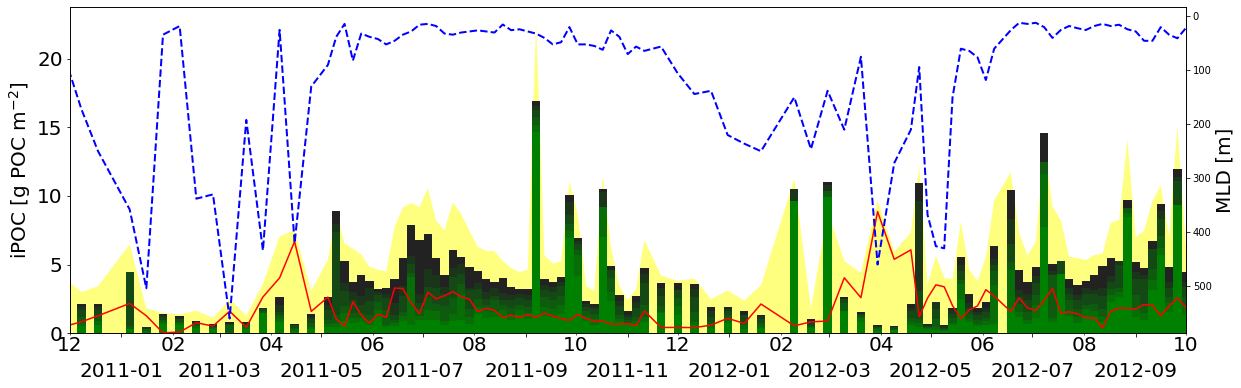

In [436]:
fig, ax = plt.subplots(figsize = (20,6))
ax2 = ax.twinx()
w = 5

#ax.plot(x, iPOC_0_1000) # Plot data on the axes.
# ax.bar(x, iPOC_zp_1000, width = w, color = pal[0])
# ax.bar(x, iPOC_zpzi50_1000, width = w, color = pal[1])
# ax.bar(x, iPOC_zpzi100_1000, width = w, color = pal[2])
# ax.bar(x, iPOC_zpzi200_1000, width = w, color = pal[3])
# ax.bar(x, iPOC_zpzi300_1000, width = w, color = pal[4])
# ax.bar(x, iPOC_zpzi400_1000, width = w, color = pal[5])

ax.bar(x, iPOC_zp_1000, width = w, color = pal[5])
ax.bar(x, iPOC_zpzi50_1000, width = w, color = pal[4])
ax.bar(x, iPOC_zpzi100_1000, width = w, color = pal[3])
ax.bar(x, iPOC_zpzi200_1000, width = w, color = pal[2])
ax.bar(x, iPOC_zpzi300_1000, width = w, color = pal[1])
ax.bar(x, iPOC_zpzi400_1000, width = w, color = pal[0])

# iPOC in the upper layer
ax.plot(x, iPOC_0_zp, color = 'red')

ax.set_ylabel('iPOC [g POC m$^{-2}$]', fontsize = 20)

# add (not smoothed) iPOC_0_1000
# Shade the area between y1 and line y=0
ax.fill_between(x, y1 = iPOC_0_1000, facecolor="yellow", alpha=.5) # The outline color

# import seaborn as sns
# seq_col_brew = sns.color_palette("gray", 5)
# sns.set_palette(seq_col_brew)

# ax.set_title(title, fontsize = 20)
# ylim([0, ymax])
# plt.gca().invert_yaxis()

#####   set ticks and  labels
months = mdates.MonthLocator(interval=1)
years = mdates.YearLocator() 

datemin = datetime.strptime('2010-12-01', '%Y-%m-%d').date()
datemin = datemin.toordinal()
datemax = datetime.strptime('2012-10-01', '%Y-%m-%d').date()
datemax = datemax.toordinal()

ax.set_xlim(datemin, datemax)

ax.xaxis.set_minor_locator(months)
ax.xaxis.set_major_locator(years)
fmt = mdates.DateFormatter('%m')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(fmt)

ax.tick_params(axis='x', which='major', direction='out', pad=25, labelsize=20)
ax.tick_params(axis='x', which='minor', direction='out', pad=0.5, labelsize=20)
ax.tick_params(axis='both', which='both', labelsize=20)

# add mld data (on another axes)
ax2.plot(time_mld, mld, 'b--', lw = 2)
ax2.set_ylabel('MLD [m]', fontsize = 20)
plt.gca().invert_yaxis()

In [437]:
data2.head(5)

,human_time,iPOC_0_1000,iPOC_0_zp,iPOC_zp_1000,iPOC_zp+zi50_1000,iPOC_zp+zi100_1000,iPOC_zp+zi200_1000,iPOC_zp+zi300_1000,iPOC_zp+zi400_1000,MLD
1,2010-07-02,10.243946,1.142337,8.458028,5.843988,4.967885,3.883744,3.126939,2.289509,18.00
684,2010-07-12,9.228206,2.962005,6.019133,4.314104,3.409405,2.407798,1.734423,1.231578,22.00
1367,2010-07-22,8.097219,2.389940,5.491047,4.661706,3.825140,2.264262,1.290348,0.884374,18.00
2051,2010-08-01,9.924965,1.122550,8.587824,6.822852,5.895650,4.112504,3.129485,2.278178,12.00
2735,2010-08-11,8.199228,1.827724,6.225577,4.918171,4.190889,2.817494,2.217046,1.184999,15.81


# Compute instantaneous fluxes (reminder : hyp that flux is 0 at 1000 m)

In [438]:
def compute_flux(dataset, var_name):
    fluxes = []
    
    for i in range(dataset.shape[0]):
        if(i == 0): 
            fluxes.append(0)
        else:
            deltaIPOC = dataset.iloc[i].loc[var_name] - dataset.iloc[i-1].loc[var_name]
            deltaT = relativedelta(dataset.iloc[i].loc['human_time'], dataset.iloc[i-1].loc['human_time'])
            deltaT = deltaT.days
            flux = (deltaIPOC/deltaT)*100 # *100 to get mg instead of g
            fluxes.append(flux)
    return(fluxes)

In [439]:
data2['flux_zpzi50_1000'] = compute_flux(data2, 'iPOC_zp+zi50_1000')
data2['flux_zpzi100_1000'] = compute_flux(data2, 'iPOC_zp+zi100_1000')
data2['flux_zpzi200_1000'] = compute_flux(data2, 'iPOC_zp+zi200_1000')
data2['flux_zpzi300_1000'] = compute_flux(data2, 'iPOC_zp+zi300_1000')
data2['flux_zpzi400_1000'] = compute_flux(data2, 'iPOC_zp+zi400_1000')
data2['flux_0_zp'] = compute_flux(data2, 'iPOC_0_zp')

In [440]:
data2.head()

,human_time,iPOC_0_1000,iPOC_0_zp,iPOC_zp_1000,iPOC_zp+zi50_1000,iPOC_zp+zi100_1000,iPOC_zp+zi200_1000,iPOC_zp+zi300_1000,iPOC_zp+zi400_1000,MLD,flux_zpzi50_1000,flux_zpzi100_1000,flux_zpzi200_1000,flux_zpzi300_1000,flux_zpzi400_1000,flux_0_zp
1,2010-07-02,10.243946,1.142337,8.458028,5.843988,4.967885,3.883744,3.126939,2.289509,18.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
684,2010-07-12,9.228206,2.962005,6.019133,4.314104,3.409405,2.407798,1.734423,1.231578,22.00,-15.298844,-15.584808,-14.759462,-13.925165,-10.579308,18.196683
1367,2010-07-22,8.097219,2.389940,5.491047,4.661706,3.825140,2.264262,1.290348,0.884374,18.00,3.476020,4.157356,-1.435358,-4.440752,-3.472034,-5.720645
2051,2010-08-01,9.924965,1.122550,8.587824,6.822852,5.895650,4.112504,3.129485,2.278178,12.00,21.611463,20.705097,18.482419,18.391377,13.938039,-12.673909
2735,2010-08-11,8.199228,1.827724,6.225577,4.918171,4.190889,2.817494,2.217046,1.184999,15.81,-19.046812,-17.047612,-12.950101,-9.124393,-10.931796,7.051749


In [441]:
# data to plot
x = np.array(data2['human_time'])
flux_zpzi50_1000 = np.array(data2['flux_zpzi50_1000'])
flux_zpzi100_1000 = np.array(data2['flux_zpzi100_1000'])
flux_zpzi200_1000 = np.array(data2['flux_zpzi200_1000'])
flux_zpzi300_1000 = np.array(data2['flux_zpzi300_1000'])
flux_zpzi400_1000 = np.array(data2['flux_zpzi400_1000'])
flux_0_zp = np.array(data2['flux_0_zp'])

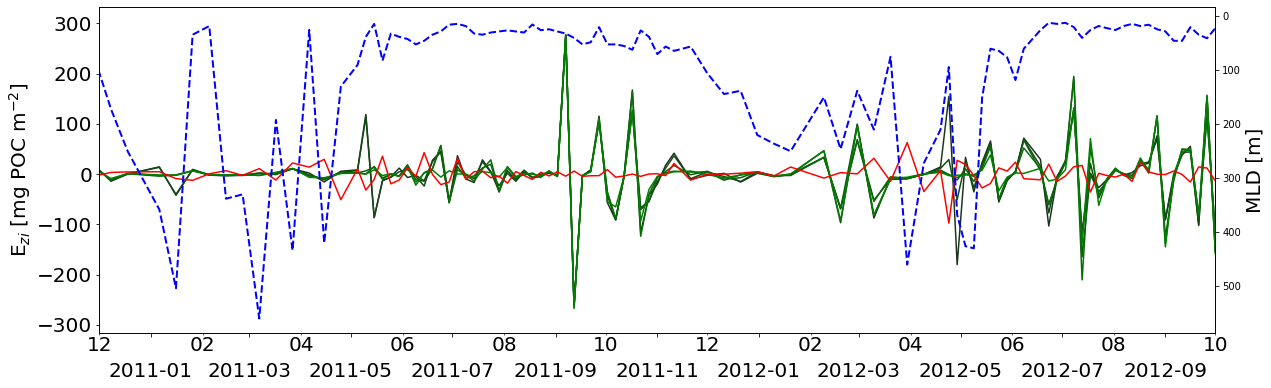

In [442]:
fig, ax = plt.subplots(figsize = (20,6))
ax2 = ax.twinx()

ax.plot(x, flux_zpzi50_1000, color = pal[4])
ax.plot(x, flux_zpzi100_1000, color = pal[3])
ax.plot(x, flux_zpzi200_1000, color = pal[2])
ax.plot(x, flux_zpzi300_1000, color = pal[1])
ax.plot(x, flux_zpzi400_1000, color = pal[0])
ax.plot(x, flux_0_zp, color = 'red')
ax.set_ylabel('E$_{zi}$ [mg POC m$^{-2}$]', fontsize = 20)

#####   set ticks and  labels
months = mdates.MonthLocator(interval=1)
years = mdates.YearLocator() 

datemin = datetime.strptime('2010-12-01', '%Y-%m-%d').date()
datemin = datemin.toordinal()
datemax = datetime.strptime('2012-10-01', '%Y-%m-%d').date()
datemax = datemax.toordinal()

ax.set_xlim(datemin, datemax)

ax.xaxis.set_minor_locator(months)
ax.xaxis.set_major_locator(years)
fmt = mdates.DateFormatter('%m')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(fmt)

ax.tick_params(axis='x', which='major', direction='out', pad=25, labelsize=20)
ax.tick_params(axis='x', which='minor', direction='out', pad=0.5, labelsize=20)
ax.tick_params(axis='both', which='both', labelsize=20)

# add mld data (on another axes)
ax2.plot(time_mld, mld, 'b--', lw = 2)
ax2.set_ylabel('MLD [m]', fontsize = 20)
plt.gca().invert_yaxis()

# TO DO
(- 1. QC the data (with the QC of 2012 first (see Dall'Olmo) but then check w/ Raphaelle Sauzede (couldn't find test in Dall'Olmo 2012))
- 1. compute the depth of the bottom of the euphotic zone (3 différents ways possible but two to really compare) => needs to be discussed and tested with the method of Lionel for the determination of z_eu
- 2. finalize the check for no POC at 1000m